Author: Nathan Hunsberger

In [3]:
import pandas as pd
import numpy as np
import re
import string
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
new_best = pd.read_csv('drive/My Drive/CS 3892/Data/lyrics_with_sentiment_47k.csv')
new_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47002 entries, 0 to 47001
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38433 non-null  float64
 1   lastfm_url              38433 non-null  object 
 2   track                   47002 non-null  object 
 3   artist                  47002 non-null  object 
 4   seeds                   38433 non-null  object 
 5   number_of_emotion_tags  38433 non-null  float64
 6   valence_tags            38433 non-null  float64
 7   arousal_tags            38433 non-null  float64
 8   dominance_tags          38433 non-null  float64
 9   mbid                    34404 non-null  object 
 10  spotify_id              47002 non-null  object 
 11  genre                   37420 non-null  object 
 12  lyrics                  46933 non-null  object 
 13  popularity              47002 non-null  float64
 14  danceability            47002 non-null

# Toy around with MGPs
Let's see about just doc2vec embedding input to audio feature output

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from google.colab import drive

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
model = Doc2Vec.load('./drive/MyDrive/CS 3892/Models/lyric_vec.bin')

In [8]:
song_data = new_best

In [9]:
# Game goal for this cell is to add a row with doc2vec embeddings
song_data['embeddings'] = [model.dv[song_id] for song_id in song_data['spotify_id']]
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47002 entries, 0 to 47001
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38433 non-null  float64
 1   lastfm_url              38433 non-null  object 
 2   track                   47002 non-null  object 
 3   artist                  47002 non-null  object 
 4   seeds                   38433 non-null  object 
 5   number_of_emotion_tags  38433 non-null  float64
 6   valence_tags            38433 non-null  float64
 7   arousal_tags            38433 non-null  float64
 8   dominance_tags          38433 non-null  float64
 9   mbid                    34404 non-null  object 
 10  spotify_id              47002 non-null  object 
 11  genre                   37420 non-null  object 
 12  lyrics                  46933 non-null  object 
 13  popularity              47002 non-null  float64
 14  danceability            47002 non-null

In [10]:
# 70 of the songs don't have lyrics (NATE WILL FIX THIS!)
lyrics = song_data[song_data['lyrics'].notnull()]
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46933 entries, 0 to 47001
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38433 non-null  float64
 1   lastfm_url              38433 non-null  object 
 2   track                   46933 non-null  object 
 3   artist                  46933 non-null  object 
 4   seeds                   38433 non-null  object 
 5   number_of_emotion_tags  38433 non-null  float64
 6   valence_tags            38433 non-null  float64
 7   arousal_tags            38433 non-null  float64
 8   dominance_tags          38433 non-null  float64
 9   mbid                    34404 non-null  object 
 10  spotify_id              46933 non-null  object 
 11  genre                   37420 non-null  object 
 12  lyrics                  46933 non-null  object 
 13  popularity              46933 non-null  float64
 14  danceability            46933 non-null

In [11]:
emotion_columns = ['fear_lyric_score', 'sadness_lyric_score', 'neutral_lyric_score', 'anger_lyric_score', 'surprise_lyric_score', 'disgust_lyric_score', 'joy_lyric_score']
song_data['best_emotion'] = song_data[emotion_columns].idxmax(axis=1)
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47002 entries, 0 to 47001
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38433 non-null  float64
 1   lastfm_url              38433 non-null  object 
 2   track                   47002 non-null  object 
 3   artist                  47002 non-null  object 
 4   seeds                   38433 non-null  object 
 5   number_of_emotion_tags  38433 non-null  float64
 6   valence_tags            38433 non-null  float64
 7   arousal_tags            38433 non-null  float64
 8   dominance_tags          38433 non-null  float64
 9   mbid                    34404 non-null  object 
 10  spotify_id              47002 non-null  object 
 11  genre                   37420 non-null  object 
 12  lyrics                  46933 non-null  object 
 13  popularity              47002 non-null  float64
 14  danceability            47002 non-null

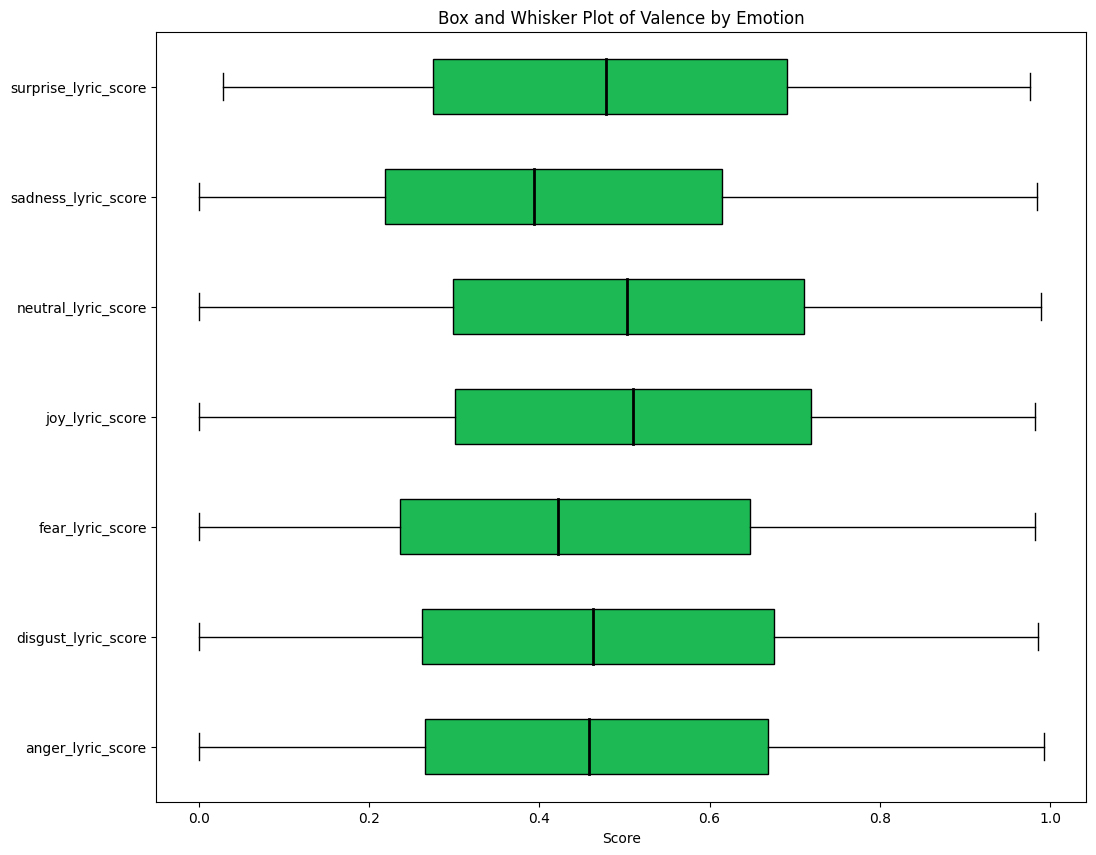

In [62]:
# Find the top 20 genres by song count
top_20_genres = song_data['genre'].value_counts().nlargest(20).index

# Filter the DataFrame to include only songs from the top 20 genres
filtered_data = song_data[song_data['genre'].isin(top_20_genres)]

# Group the filtered data by genre and aggregate valence
grouped_valence = song_data.groupby('best_emotion')['valence'].apply(list)

# Prepare the data for plotting
genres = grouped_valence.index.tolist()
valence_data = grouped_valence.tolist()

# Plotting
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
plt.boxplot(valence_data, vert=False, patch_artist=True,
            medianprops=dict(linestyle='-', linewidth=2, color='black'),
            boxprops=dict(facecolor='#1DB954'))

# Setting the labels for each boxplot
plt.yticks(range(1, len(genres) + 1), genres)

plt.xlabel('Score')
plt.title('Box and Whisker Plot of Valence by Emotion')
plt.show()


Text(0.5, 1.0, 'Tempo vs Danceability')

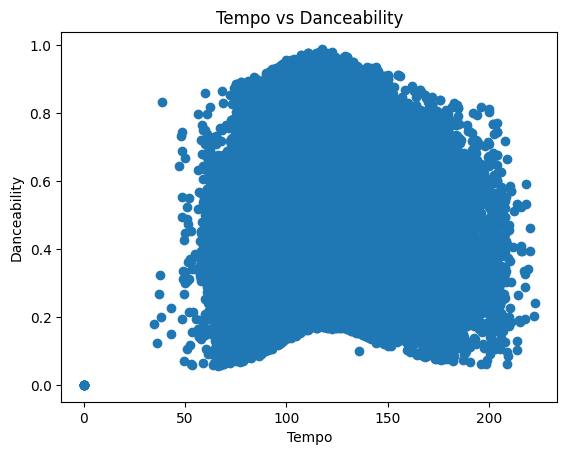

In [74]:
plt.scatter(song_data['tempo'], song_data['danceability'])
plt.xlabel("Tempo")
plt.ylabel("Danceability")
plt.title("Tempo vs Danceability")

Hm. Not sure there's much valence difference by genre. We gonna hope the emotion labels do better

In [12]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.0 MB/s eta 0:00:00


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

input_columns = ['embeddings', 'fear_lyric_score', 'sadness_lyric_score', 'neutral_lyric_score', 'anger_lyric_score', 'surprise_lyric_score', 'disgust_lyric_score', 'joy_lyric_score']


# Extract embeddings as inputs
X = torch.tensor(lyrics['embeddings'].tolist(), dtype=torch.float32)
X_2 = torch.tensor(lyrics[input_columns[1:]].values, dtype=torch.float32)
X = torch.column_stack((X, X_2))

# Initialize the scaler
scaler = MinMaxScaler()

# Reshape tempo for scaling (sklearn expects 2D array)
tempo = lyrics['tempo'].values.reshape(-1, 1)

# Scale the tempo
scaled_tempo = scaler.fit_transform(tempo)

# Replace the original tempo column with the scaled tempo
lyrics['scaled_tempo'] = scaled_tempo

# Extract the targets
y = torch.tensor(lyrics[['valence', 'scaled_tempo', 'energy', 'danceability']].values, dtype=torch.float32)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)

<ipython-input-13-bfdc9690bd38>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor(lyrics['embeddings'].tolist(), dtype=torch.float32)
<ipython-input-13-bfdc9690bd38>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics['scaled_tempo'] = scaled_tempo


In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
import torch
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy, IndependentMultitaskVariationalStrategy
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.means import ConstantMean, MultitaskMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultitaskMultivariateNormal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultitaskSparseGPModel(ApproximateGP):
    def __init__(self, inducing_points, num_tasks=4):
        # Base variational distribution and strategy
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), batch_shape=torch.Size([num_tasks]))
        variational_strategy = IndependentMultitaskVariationalStrategy(
            VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks
        )
        # variational_strategy = VariationalStrategy(
        #     self, inducing_points, variational_distribution, learn_inducing_locations=True
        # )

        # Wrap the base strategy with IndependentMultitaskVariationalStrategy
        # variational_strategy = IndependentMultitaskVariationalStrategy(
        #     variational_strategy, num_tasks=num_tasks
        # )

        super(MultitaskSparseGPModel, self).__init__(variational_strategy)
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


X_train, y_train = X_train.to(device), y_train.to(device)
# Select inducing points
inducing_points = X_train[:500, :]  # Subset of data as inducing points

# Initialize model and likelihood on the GPU
model = MultitaskSparseGPModel(inducing_points=inducing_points, num_tasks=4).to(device)
likelihood = MultitaskGaussianLikelihood(num_tasks=4).to(device)

EPOCH: 0, Loss: 4.419018187352299
EPOCH: 1, Loss: 4.393504002228303
EPOCH: 2, Loss: 4.392543354879246
EPOCH: 3, Loss: 4.392051354786809
EPOCH: 4, Loss: 4.3917572916670995
EPOCH: 5, Loss: 4.391555903108197
EPOCH: 6, Loss: 4.391400617472764
EPOCH: 7, Loss: 4.3912691533870145
EPOCH: 8, Loss: 4.391150134182464
EPOCH: 9, Loss: 4.391039161097252
EPOCH: 10, Loss: 4.390936165083409
EPOCH: 11, Loss: 4.390843343491042
EPOCH: 12, Loss: 4.390763420871819
EPOCH: 13, Loss: 4.39069789109888
EPOCH: 14, Loss: 4.390646607140666
EPOCH: 15, Loss: 4.390607937028095
EPOCH: 16, Loss: 4.390579379599992
EPOCH: 17, Loss: 4.390558086830672
EPOCH: 18, Loss: 4.3905412561848784
EPOCH: 19, Loss: 4.390526664317974
EPOCH: 20, Loss: 4.390512749121177
EPOCH: 21, Loss: 4.390498148318653
EPOCH: 22, Loss: 4.39048299350771
EPOCH: 23, Loss: 4.390468670521725
EPOCH: 24, Loss: 4.390456840573624
EPOCH: 25, Loss: 4.390447523159307
EPOCH: 26, Loss: 4.390438932779498
EPOCH: 27, Loss: 4.390430281475009
EPOCH: 28, Loss: 4.3904211687

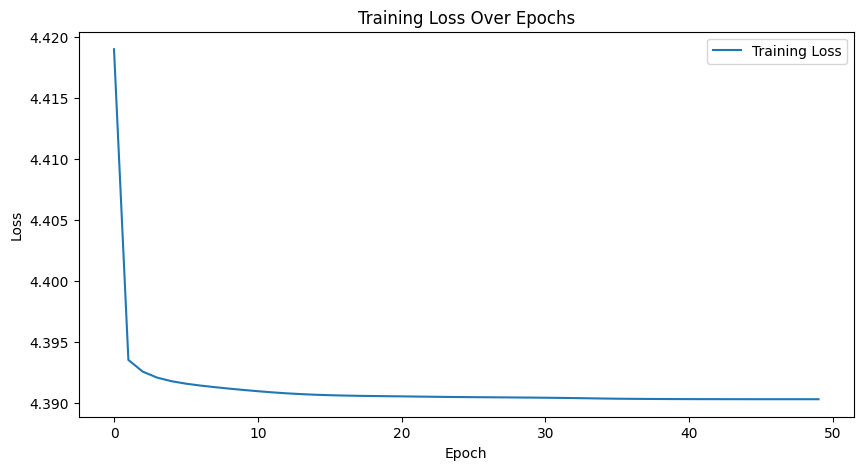

In [83]:
from gpytorch.mlls import VariationalELBO
from torch.optim import Adam

# Optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# The ELBO objective
mll = VariationalELBO(likelihood, model, num_data=y_train.size(0))

# Training loop
model.train()
likelihood.train()

num_epochs = 50
losses = []  # List to store loss values
for epoch in range(num_epochs):
    epoch_loss = 0  # Variable to store loss for the current epoch
    for x_batch, y_batch in train_loader:
        # Move batch to the GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate the average loss for the current epoch
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f"EPOCH: {epoch}, Loss: {epoch_loss}")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [33]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test.to(device)))
    mean = predictions.mean

In [17]:
model.load_state_dict(torch.load("./drive/MyDrive/CS 3892/Models/mgp-no-doc2vec.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

In [20]:
# Initialize variables for MSE calculations
test_mse_total = 0.0
test_mse_valence = 0.0
test_mse_tempo = 0.0
test_mse_energy = 0.0
test_mse_danceability = 0.0

# Count the number of test samples
num_test_samples = 0

# Switch to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for x_batch, y_batch in test_loader:
        # Move batch to the GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Make predictions
        predictions = model(x_batch)
        # Get the mean of predictions
        predicted_means = predictions.mean

        # Compute MSE for each output feature
        test_mse_valence += torch.mean((predicted_means[:, 0] - y_batch[:, 0]) ** 2).item()
        test_mse_tempo += torch.mean((predicted_means[:, 1] - y_batch[:, 1]) ** 2).item()
        test_mse_energy += torch.mean((predicted_means[:, 2] - y_batch[:, 2]) ** 2).item()
        test_mse_danceability += torch.mean((predicted_means[:, 3] - y_batch[:, 3]) ** 2).item()

        # Compute overall MSE
        test_mse_total += torch.mean((predicted_means - y_batch) ** 2).item()

        # Update the total number of test samples
        num_test_samples += y_batch.size(0)

# Average MSE over the test set
test_mse_total /= num_test_samples
test_mse_valence /= num_test_samples
test_mse_tempo /= num_test_samples
test_mse_energy /= num_test_samples
test_mse_danceability /= num_test_samples

print(f"Overall Test MSE: {test_mse_total * 100}")
print(f"Test MSE for Valence: {test_mse_valence * 100}")
print(f"Test MSE for Tempo: {test_mse_tempo * 100}")
print(f"Test MSE for Energy: {test_mse_energy * 100}")
print(f"Test MSE for Danceability: {test_mse_danceability * 100}")


Overall Test MSE: 0.06533135087825091
Test MSE for Valence: 0.09961341017317668
Test MSE for Tempo: 0.026304379230180818
Test MSE for Energy: 0.09063974866581836
Test MSE for Danceability: 0.0447678655430419


In [89]:
# Switch to evaluation mode
model.eval()
likelihood.eval()

test_mse = 0.0
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for x_batch, y_batch in test_loader:
        # Move batch to the GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Make predictions
        predictions = model(x_batch)
        # Get the mean of predictions
        predicted_means = predictions.mean

        # predicted_tempo = predicted_means[:, 1]

        # # Reshape for inverse scaling
        # predicted_tempo = predicted_tempo.reshape(-1, 1)

        # # Apply inverse transformation to scale back to original range
        # original_scale_tempo = scaler.inverse_transform(predicted_tempo.cpu())

        # # Replace the scaled tempo in your predictions with the original scale
        # predicted_means[:, 1] = torch.tensor(original_scale_tempo).squeeze()

        # y_tempo = y_batch[:, 1]

        # # Reshape for inverse scaling
        # y_tempo = y_tempo.reshape(-1, 1)

        # # Apply inverse transformation to scale back to original range
        # scaled_tempo = scaler.inverse_transform(y_tempo.cpu())

        # # Replace the scaled tempo in your predictions with the original scale
        # y_batch[:, 1] = torch.tensor(scaled_tempo).squeeze()


        # Compute MSE
        test_mse += torch.mean((predicted_means - y_batch) ** 2).item()

# Average MSE over the test set
test_mse /= len(test_loader)

print(f"Test MSE: {test_mse}")


Test MSE: 0.04171873428890494


In [84]:
torch.save(model.state_dict(), "./drive/MyDrive/CS 3892/Models/mgp-no-doc2vec.pth")

# model.save("./drive/MyDrive/CS 3892/Models/mgp.pt")